In [1]:
import elettrocablaggi
from mrcnn import visualize
from mrcnn import utils
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
import mrcnn.model as modellib

import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


### Dataset location info

In [2]:
info = {'train': {'label_file_path':"../../dataset/elettrocablaggi_20200921/train/annots/labels.txt",
                   'annotation_dir': "../../dataset/elettrocablaggi_20200921/train/annots/",
                   'images_dir': "../../dataset/elettrocablaggi_20200921/train/images/"},
         'test':{'label_file_path':"../../dataset/elettrocablaggi_20200921/test/annots/labels.txt",
                   'annotation_dir': "../../dataset/elettrocablaggi_20200921/test/real/annots/",
                   'images_dir': "../../dataset/elettrocablaggi_20200921/test/real/images/"},
         'saved_model_dir': "../../weights/elettrocablaggi_20200921/"}

### Load training and test set

In [3]:
# Training dataset
dataset_train = elettrocablaggi.ElettrocablaggiDataset()
class_info, train_image_info = dataset_train.load_elettrocablaggi(info['train']['label_file_path'], 
                                                                  info['train']['annotation_dir'], 
                                                                  info['train']['images_dir'])
dataset_train.prepare()

# Validation dataset
dataset_val = elettrocablaggi.ElettrocablaggiDataset()
class_info, val_image_info = dataset_val.load_elettrocablaggi(info['test']['label_file_path'], 
                                                              info['test']['annotation_dir'], 
                                                              info['test']['images_dir'])
dataset_val.prepare()

print("Training set: ", len(train_image_info))
print("Test set: ", len(val_image_info))
print("Class info:", class_info)

Training set:  8000
Test set:  27
Class info: [{'source': '', 'id': 0, 'name': 'BG'}, {'source': 'elettrocablaggi', 'id': 0, 'name': '0'}, {'source': 'elettrocablaggi', 'id': 1, 'name': '1'}, {'source': 'elettrocablaggi', 'id': 2, 'name': '2'}, {'source': 'elettrocablaggi', 'id': 3, 'name': '3'}, {'source': 'elettrocablaggi', 'id': 4, 'name': '4'}, {'source': 'elettrocablaggi', 'id': 5, 'name': '5'}, {'source': 'elettrocablaggi', 'id': 6, 'name': '6'}, {'source': 'elettrocablaggi', 'id': 7, 'name': '7'}, {'source': 'elettrocablaggi', 'id': 8, 'name': '8'}, {'source': 'elettrocablaggi', 'id': 9, 'name': '9'}, {'source': 'elettrocablaggi', 'id': 10, 'name': '10'}, {'source': 'elettrocablaggi', 'id': 11, 'name': '11'}]


### Display random samples for training e validation set

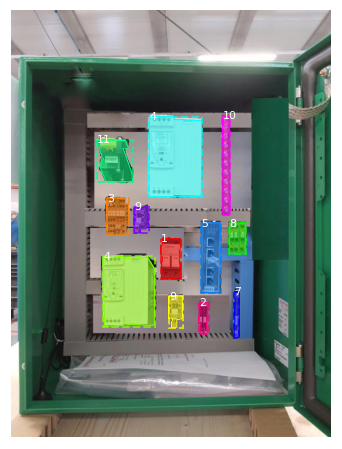

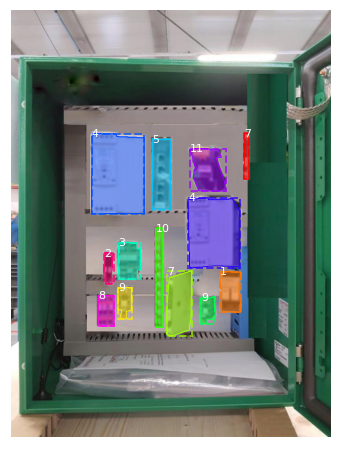

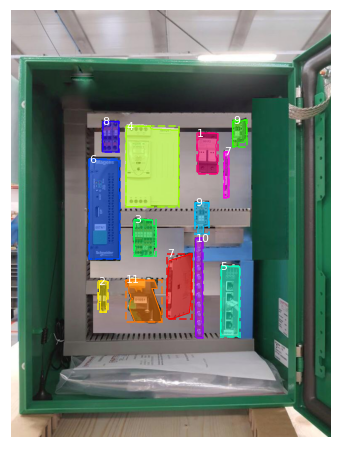

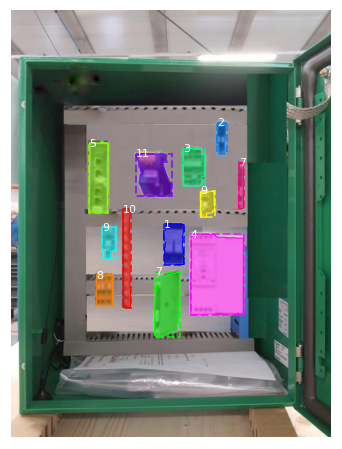

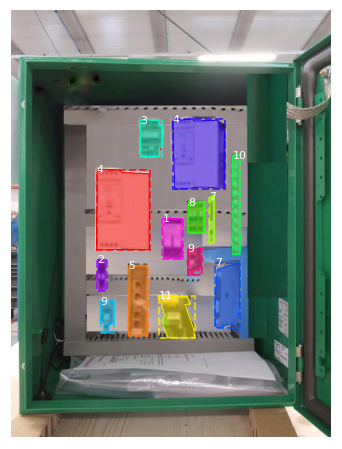

In [9]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 5)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_instances(image, utils.extract_bboxes(mask), mask, class_ids, 
                            dataset_train.class_names, figsize=(8, 8))

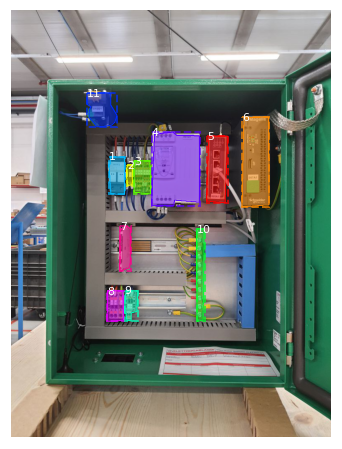

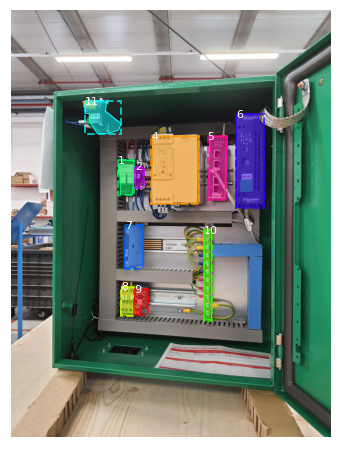

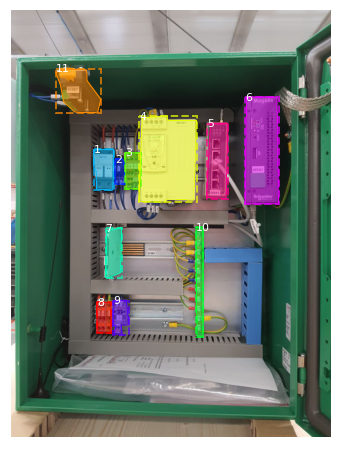

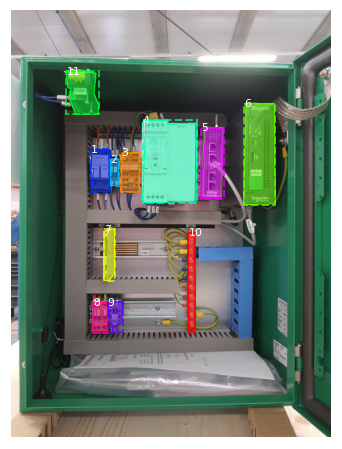

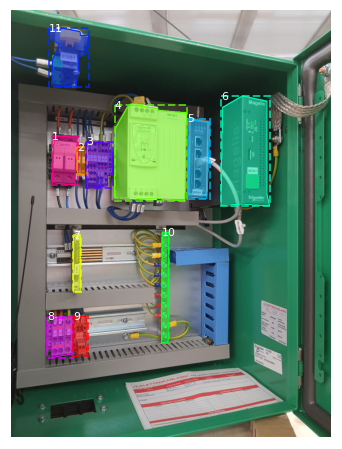

In [10]:
# Load and display random samples
image_ids = np.random.choice(dataset_val.image_ids, 5)
for image_id in image_ids:
    image = dataset_val.load_image(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)
    visualize.display_instances(image, utils.extract_bboxes(mask), mask, class_ids, 
                            dataset_val.class_names, figsize=(8, 8))

### Diplay model config for training

In [5]:
# Create config class containing training properties
config = elettrocablaggi.ElettrocablaggiConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  320
IMAGE_META_SIZE                25
IMAGE_MIN_DIM                  320
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [320 320   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE            

### Load trainend weight

In [ ]:
inference_config = elettrocablaggi.ElettrocablaggiInferenceConfig()

# create the model in inference mode
model = modellib.MaskRCNN(mode="inference",
                          config=inference_config,
                          model_dir=info['saved_model_dir'])

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

### Display random prediction

In [8]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size * cols, size * rows))
    return fig, ax

In [ ]:
dataset_val.prepare()

samples = 5
replace = False

image_ids = np.random.choice(dataset_val.image_ids, samples, replace=replace)

APs = []
for image_id in image_ids:
    # load original image
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_val,
                                                                                       inference_config,
                                                                                       image_id,
                                                                                       use_mini_mask=False)

    # infer on original image
    results = model.detect([original_image], verbose=1)
    r = results[0]

    # draw result of inferred masks on the original image
    fig, ax = get_ax()
    masked_image = visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'],
                                               dataset_val.class_names, r['scores'], ax=ax)
    
    AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                                             r["rois"], r["class_ids"], r["scores"], r['masks'])
    print("AP:", AP)
    print("precision:", precisions)
    print("recall:", recalls)
    print("overlap:", overlaps)
    APs.append(AP)

    print("\n\n")

print("mAP: ", np.mean(APs))


### Tensorboard

In [11]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
%tensorboard --logdir model_path